In [1]:
import sys

sys.path.append("../")
from config.get_config import get_config

# Load Data

In [2]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import mlflow

from sklearn.metrics import mean_squared_error

In [3]:
sys.path.append("../src")
from pipeline.factory import Factory
from preprocessing.process_raw_data import load_data

config = dict(get_config())
data_config = dict(config["data"])

mlflow.set_tracking_uri('http://0.0.0.0:5000')
e = mlflow.set_experiment(data_config['mlflow_experiment_name'])

mlflow.start_run(experiment_id=e.experiment_id)

2024-01-24 18:46:27.203237: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-24 18:46:27.262628: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-24 18:46:27.262714: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-24 18:46:27.262737: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-24 18:46:27.273590: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-24 18:46:27.274665: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

<ActiveRun: >

In [4]:
# fix paths
for k, v in data_config["paths"].items():
    for k2, v2 in v.items():
        data_config["paths"][k][k2] = "../" + v2

In [5]:
df = load_data(data_config["paths"])
f = Factory(data_config)
f.fit(df)

Fitting data ...


## Data Viz

In [6]:
train, val = f.get_df()
data = pd.concat([train, val])

In [7]:
train.head()

,onpromotion,dcoilwtico,cluster,sales,typedays_Additional,typedays_Event,typedays_Holiday,typedays_Normal
2013-01-01,0.0,0.792965,0.0,2511.618999,False,False,True,False
2013-01-02,0.0,0.792965,0.0,496092.417944,False,False,False,True
2013-01-03,0.0,0.790951,0.0,361461.231124,False,False,False,True
2013-01-04,0.0,0.792728,0.0,354459.677093,False,False,False,True
2013-01-05,0.0,0.793044,0.0,348347.385084,False,False,False,True


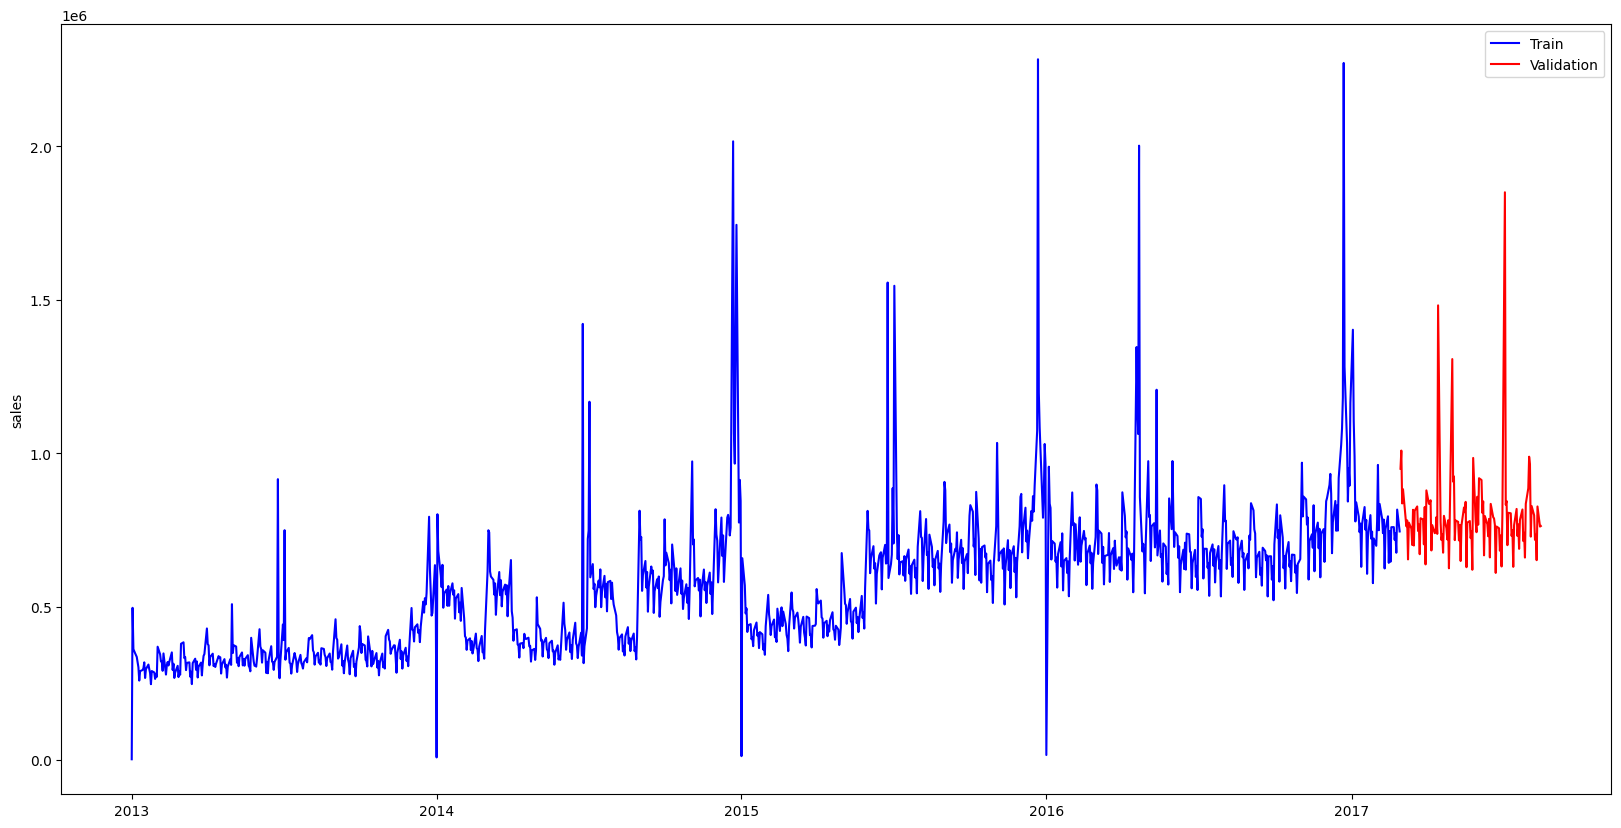

In [8]:
plt.figure(figsize=(20, 10))
sns.lineplot(data=train, x=train.index, y="sales", color="blue", label="Train")
sns.lineplot(data=val, x=val.index, y="sales", color="red", label="Validation")
plt.legend()

# Models fit

In [9]:
def predict_and_plot(model_name):
    model_type = model_name.split(" ")[0]
    model = model_name.split(" ")[1]
    local_config = config[model_type][model]
    
    f.load_model(model_name, local_config)
    pred = f.predict()
    
    assert len(pred) == len(val)
    
    df = pd.DataFrame(pred, columns=["yhat"])
    plt.figure(figsize=(20, 10))
    sns.lineplot(data=df, x=val.index, y="yhat", color="red", label=f"{model_type} Prediction")
    sns.lineplot(data=val, x=val.index, y="sales", color="blue", label="Validation") 

## Prophet

/home/acaille/.cache/pypoetry/virtualenvs/stores-sales-forecasting-poc-oU5uZx8Y-py3.10/lib/python3.10/site-packages/mlflow/store/artifact/utils/models.py:32: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.9.2/model-registry.html#migrating-from-stages
  latest = client.get_latest_versions(name, None if stage is None else [stage])

<class 'prophet.forecaster.Prophet'>


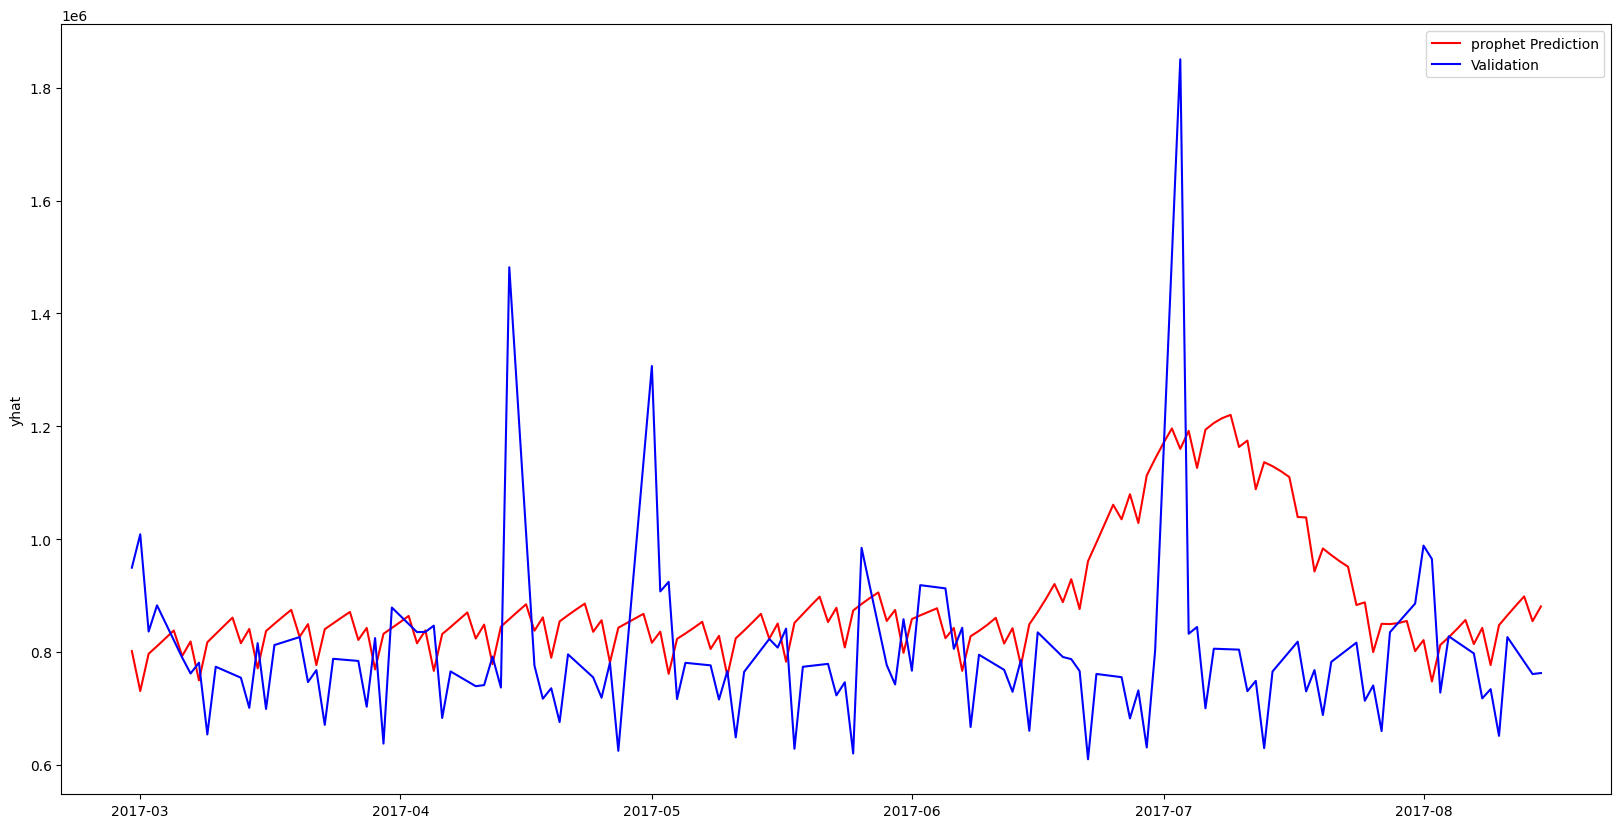

In [10]:
predict_and_plot("prophet default - 2024-01-23 13:34:58")

In [11]:
f.load_model("prophet default - 2024-01-22 11:22:01", config["prophet"]["default"])
prophet_pred = f.predict()

assert len(prophet_pred) == len(val.index)

/home/acaille/.cache/pypoetry/virtualenvs/stores-sales-forecasting-poc-oU5uZx8Y-py3.10/lib/python3.10/site-packages/mlflow/store/artifact/utils/models.py:32: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.9.2/model-registry.html#migrating-from-stages
  latest = client.get_latest_versions(name, None if stage is None else [stage])


RestException: RESOURCE_DOES_NOT_EXIST: Registered Model with name=prophet default - 2024-01-22 11:22:01 not found

<Axes: ylabel='yhat'>

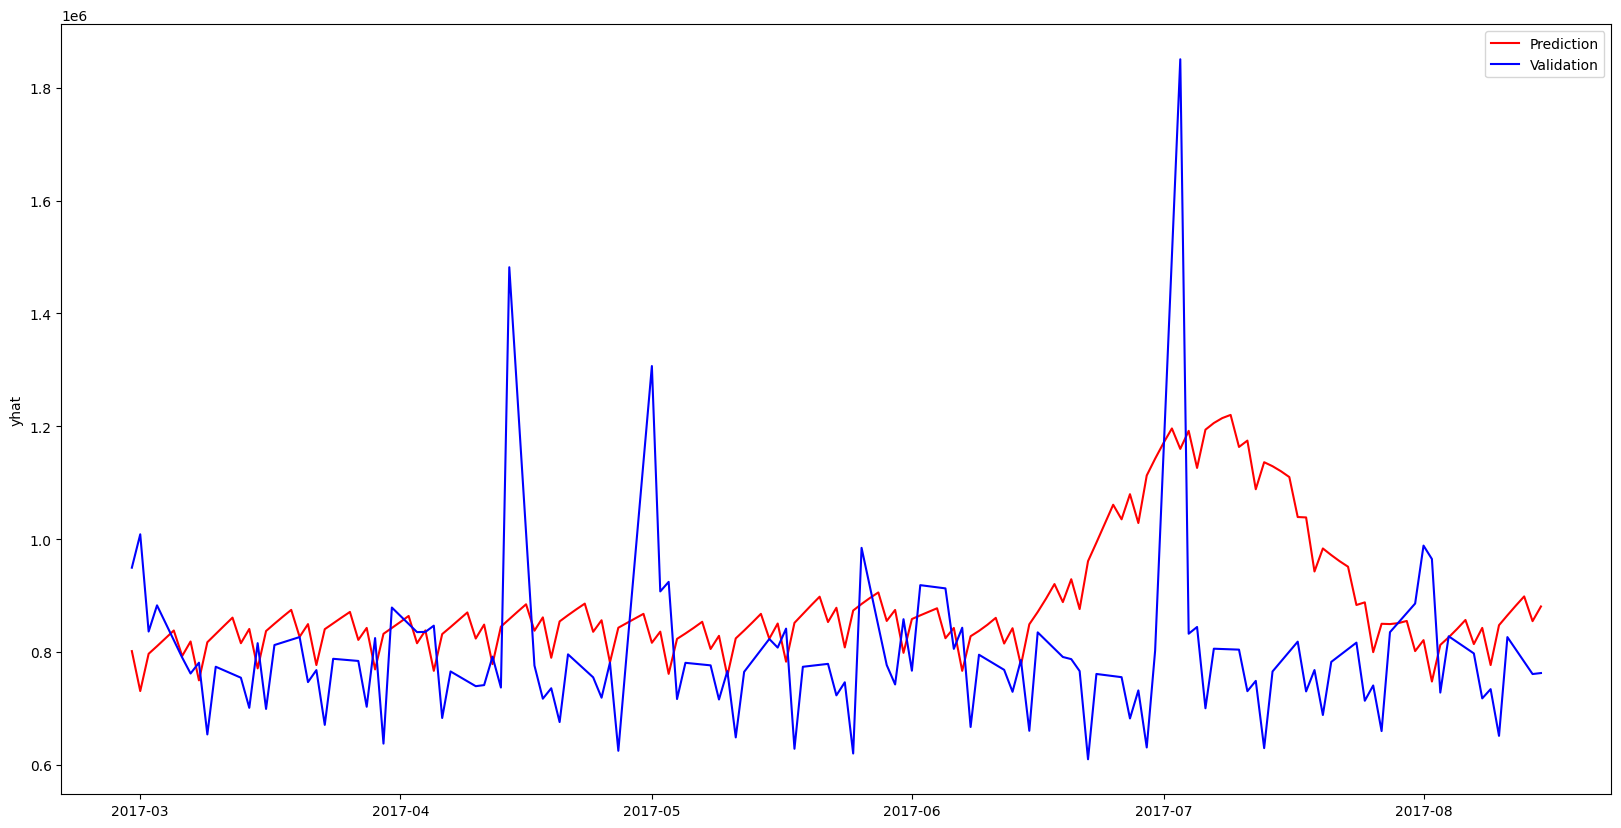

In [ ]:
prophet_df = pd.DataFrame(prophet_pred, columns=["yhat"])

plt.figure(figsize=(20, 10))
sns.lineplot(data=prophet_df, x=val.index, y='yhat', color="red", label="Prediction")
sns.lineplot(data=val, x=val.index, y="sales", color="blue", label="Validation")

## Prophet changepoint prior scale

In [ ]:
f.load_model("prophet changepoint_prior_scale_0_5 - 2024-01-23 10:40:15", config["prophet"]["changepoint_prior_scale_0_5"])
prophet_pred1 = f.predict()

assert len(prophet_pred1) == len(val.index)

<Axes: ylabel='yhat'>

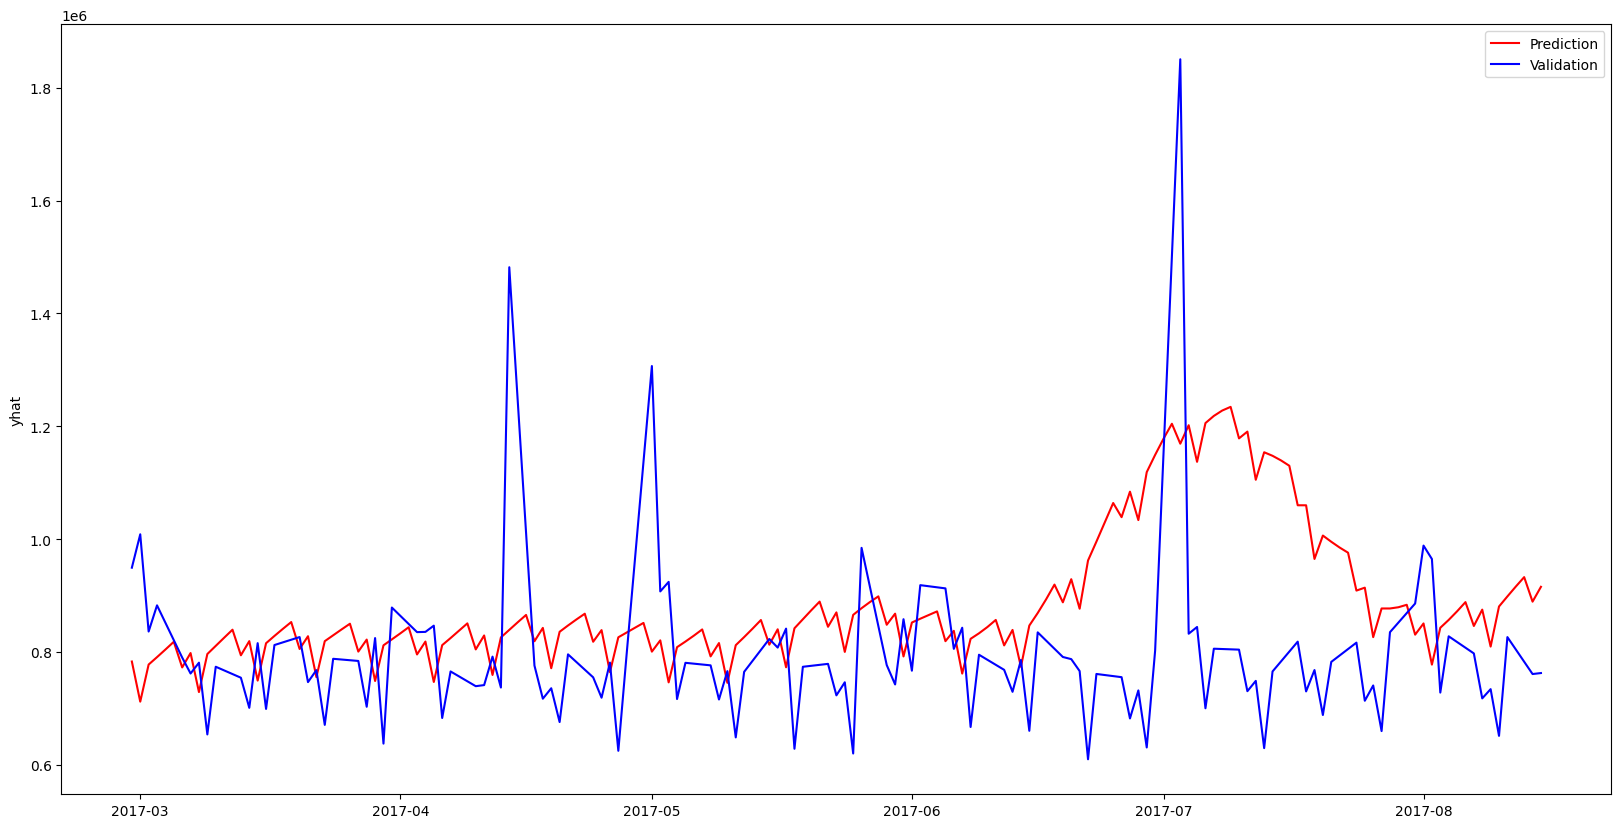

In [ ]:
prophet_df1 = pd.DataFrame(prophet_pred1)

plt.figure(figsize=(20, 10))
sns.lineplot(data=prophet_df1, x=val.index, y='yhat', color="red", label="Prediction")
sns.lineplot(data=val, x=val.index, y="sales", color="blue", label="Validation")

## Xgboost

In [ ]:
f.load_model("xgboost default - 2024-01-22 12:11:45", config["xgboost"]["default"])
xg_pred = f.predict()

assert len(xg_pred) == len(val.index)

<Axes: ylabel='pred'>

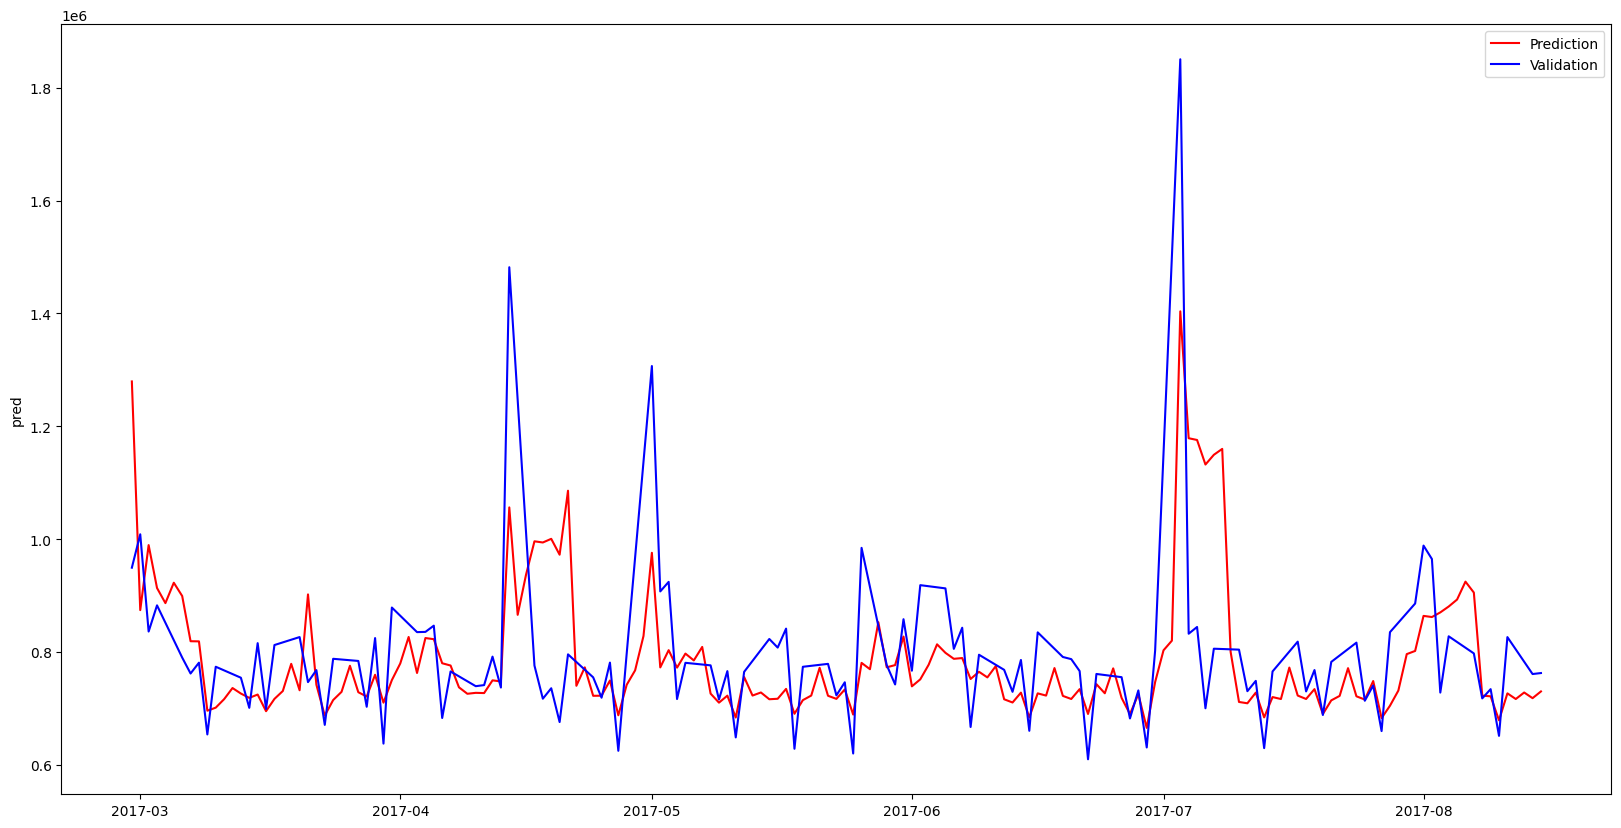

In [ ]:
xg_pred_df = pd.DataFrame(xg_pred, columns=["pred"])

plt.figure(figsize=(20, 10))
sns.lineplot(data=xg_pred_df, x=val.index, y='pred', color="red", label="Prediction")
sns.lineplot(data=val, x=val.index, y="sales", color="blue", label="Validation")

## LSTM simple

In [ ]:
f.load_model("lstm default_simple - 2024-01-22 11:27:38", config["lstm"]["default_simple"])
simple_pred = f.predict()

assert len(simple_pred) == len(val.index)

169/169 [==============================] - 1s 3ms/step


<Axes: ylabel='pred'>

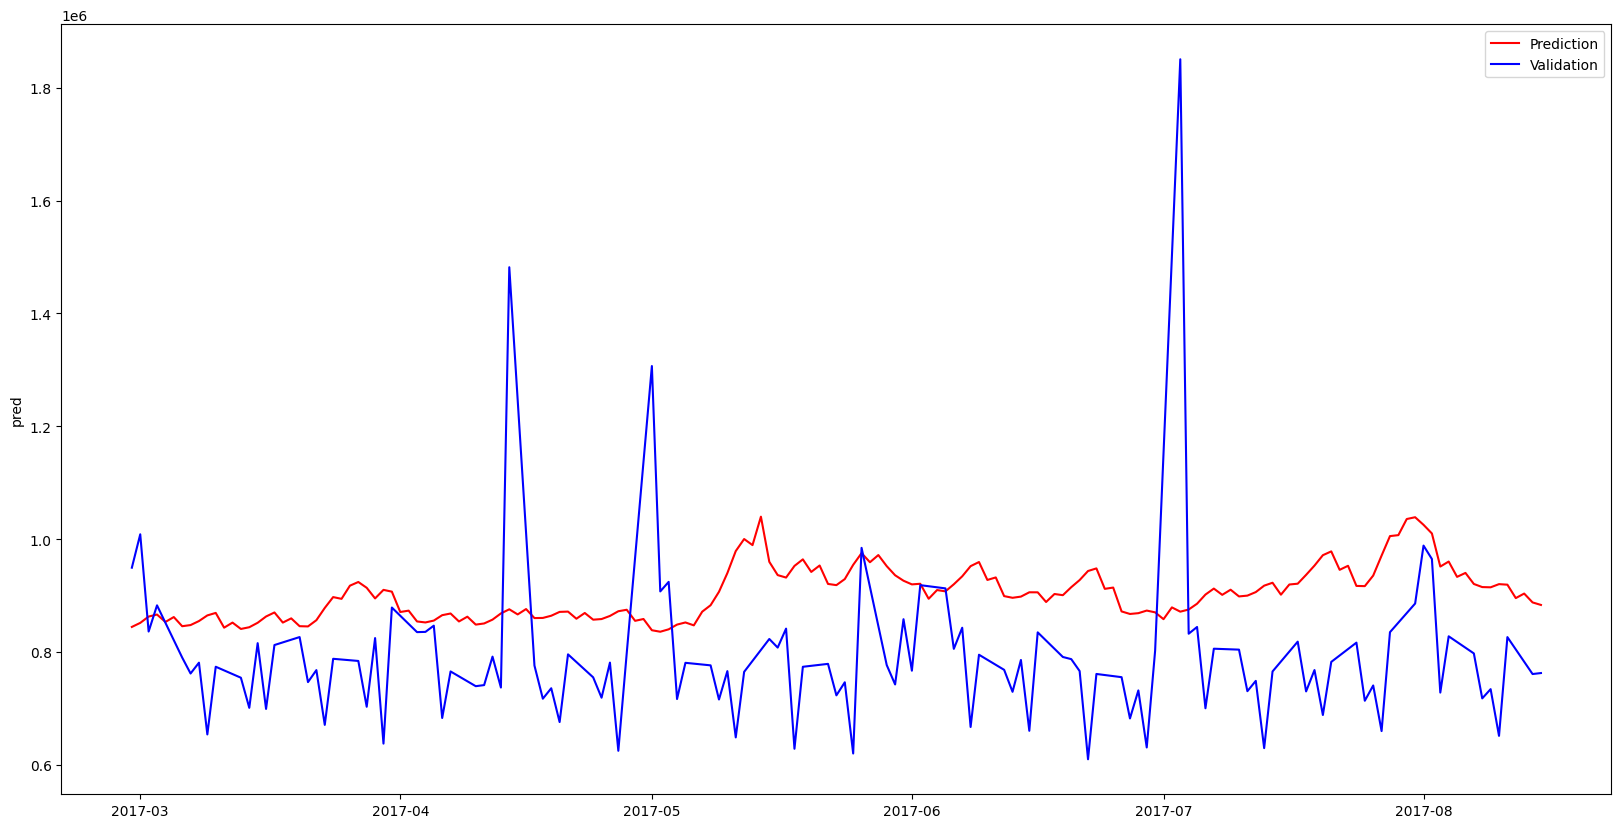

In [ ]:
simple_df = pd.DataFrame(simple_pred, columns=["pred"])

plt.figure(figsize=(20, 10))
sns.lineplot(data=simple_df, x=val.index, y='pred', color="red", label="Prediction")
sns.lineplot(data=val, x=val.index, y="sales", color="blue", label="Validation")

## LSTM multivariate

In [ ]:
f.load_model("lstm default_multivariate - 2024-01-22 13:06:43", config["lstm"]["default_multivariate"])
multi_pred = f.predict()[:, -1]

assert len(multi_pred) == len(val.index)

169/169 [==============================] - 1s 2ms/step


<Axes: ylabel='pred'>

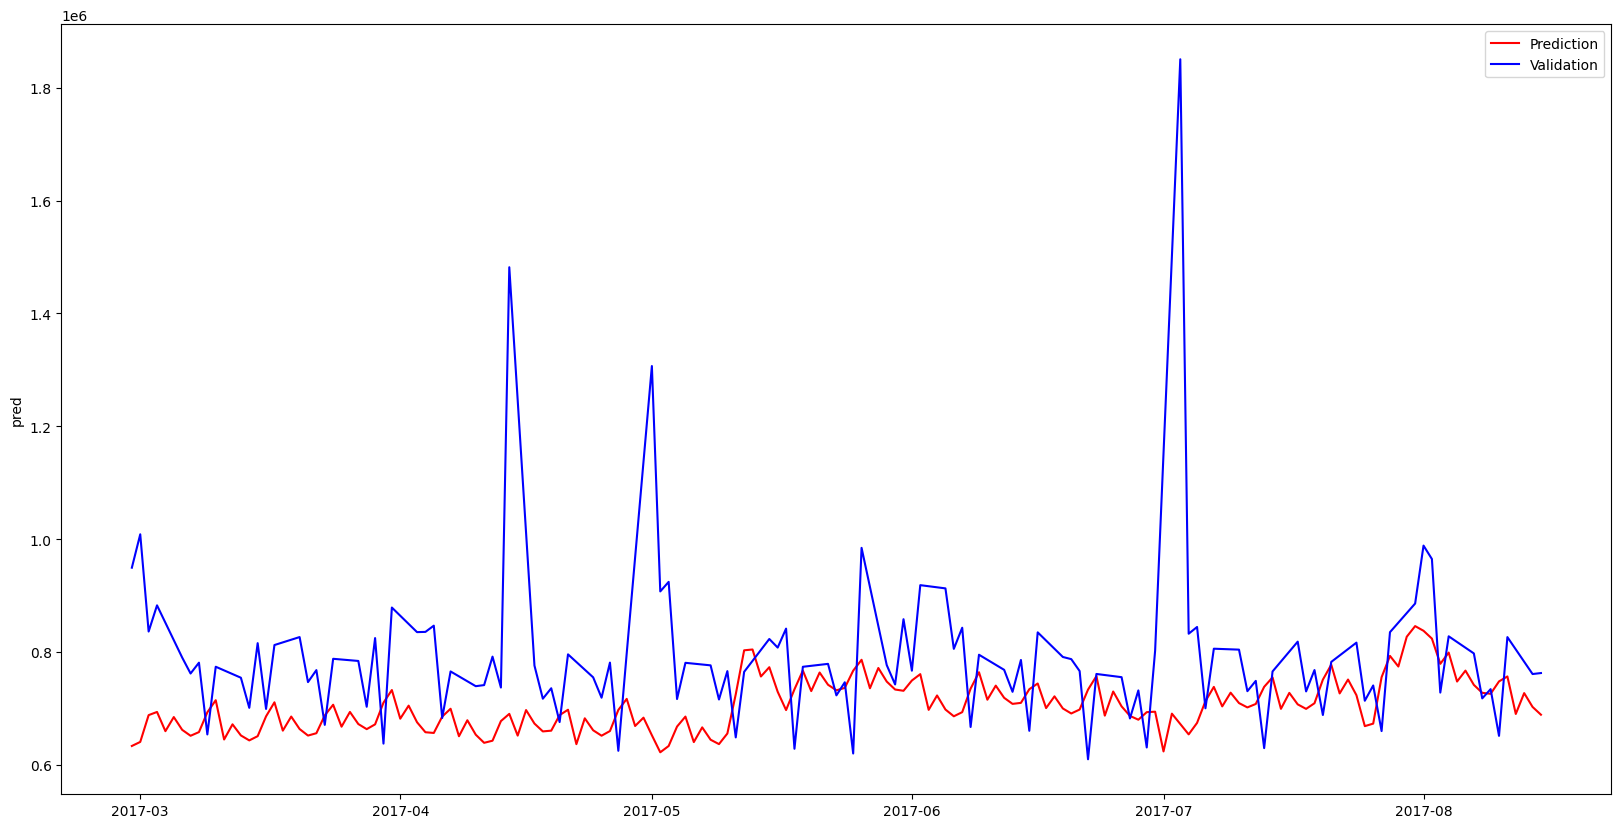

In [ ]:
multi_df = pd.DataFrame(multi_pred, columns=["pred"])

plt.figure(figsize=(20, 10))
sns.lineplot(data=multi_df, x=val.index, y='pred', color="red", label="Prediction")
sns.lineplot(data=val, x=val.index, y="sales", color="blue", label="Validation")

## LSTM simple batch size 128 look back 5

In [ ]:
f.load_model("lstm simple_batch_size_128_look_back_5 - 2024-01-23 09:34:14", config["lstm"]["simple_batch_size_128_look_back_5"])
x = f.predict()

assert len(x) == len(val.index)

169/169 [==============================] - 0s 2ms/step


<Axes: ylabel='pred'>

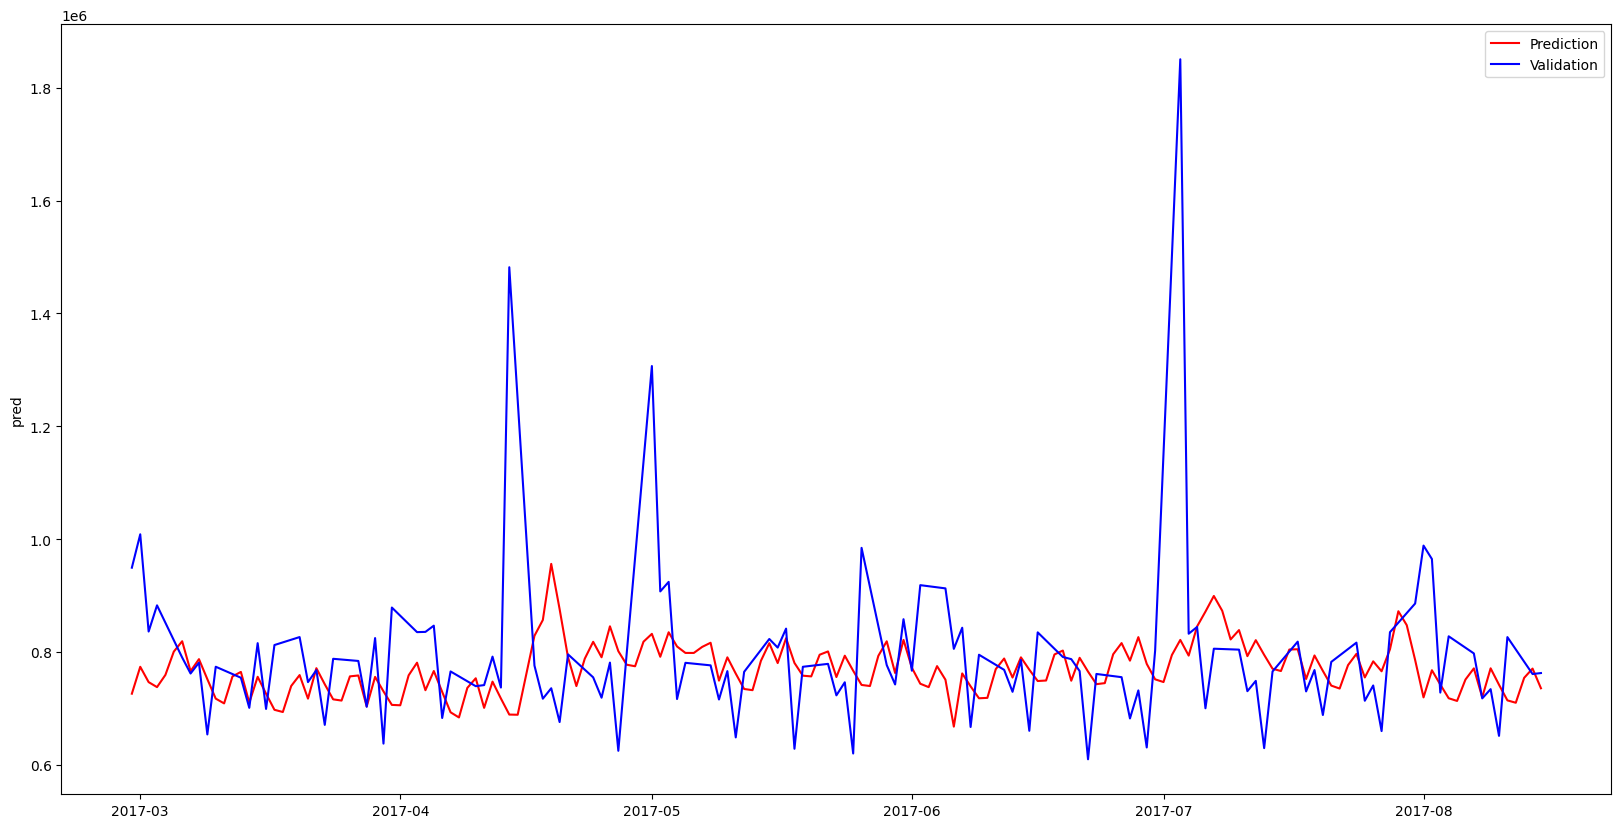

In [ ]:
x_df = pd.DataFrame(x, columns=["pred"])

plt.figure(figsize=(20, 10))
sns.lineplot(data=x_df, x=val.index, y='pred', color="red", label="Prediction")
sns.lineplot(data=val, x=val.index, y="sales", color="blue", label="Validation")

## LSTM simple l1 0.1 l2 0.1

In [ ]:
f.load_model("lstm simple_default_l1_0_01_l2_0_01 - 2024-01-23 10:20:43", config["lstm"]["simple_default_l1_0_01_l2_0_01"])
x1 = f.predict()

assert len(x) == len(val.index)

169/169 [==============================] - 0s 2ms/step


<Axes: ylabel='pred'>

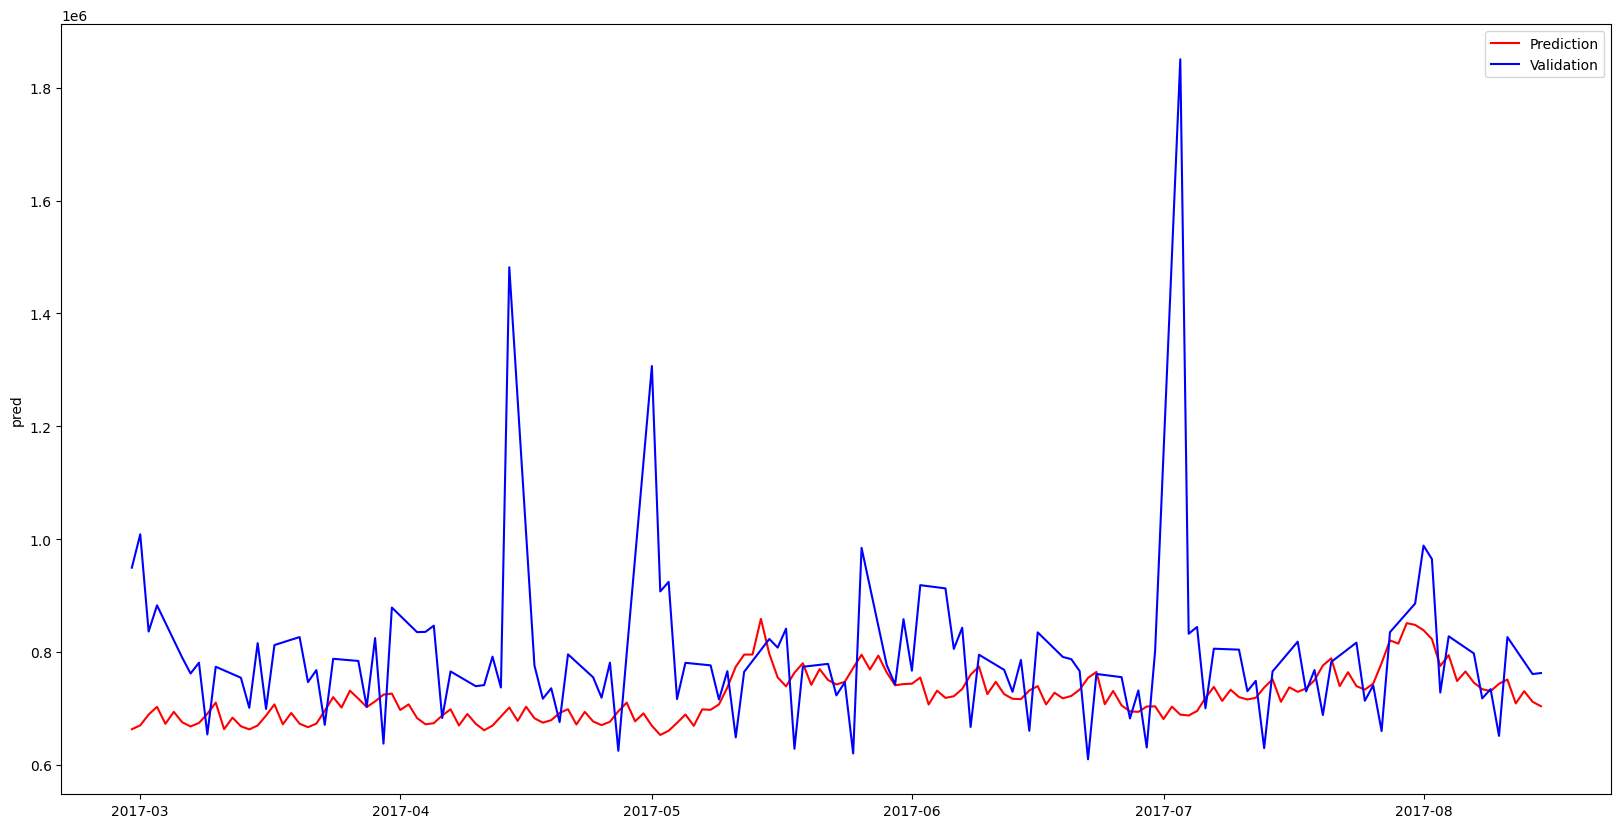

In [ ]:
x1_df = pd.DataFrame(x1, columns=["pred"])

plt.figure(figsize=(20, 10))
sns.lineplot(data=x1_df, x=val.index, y='pred', color="red", label="Prediction")
sns.lineplot(data=val, x=val.index, y="sales", color="blue", label="Validation")

<Axes: ylabel='pred'>

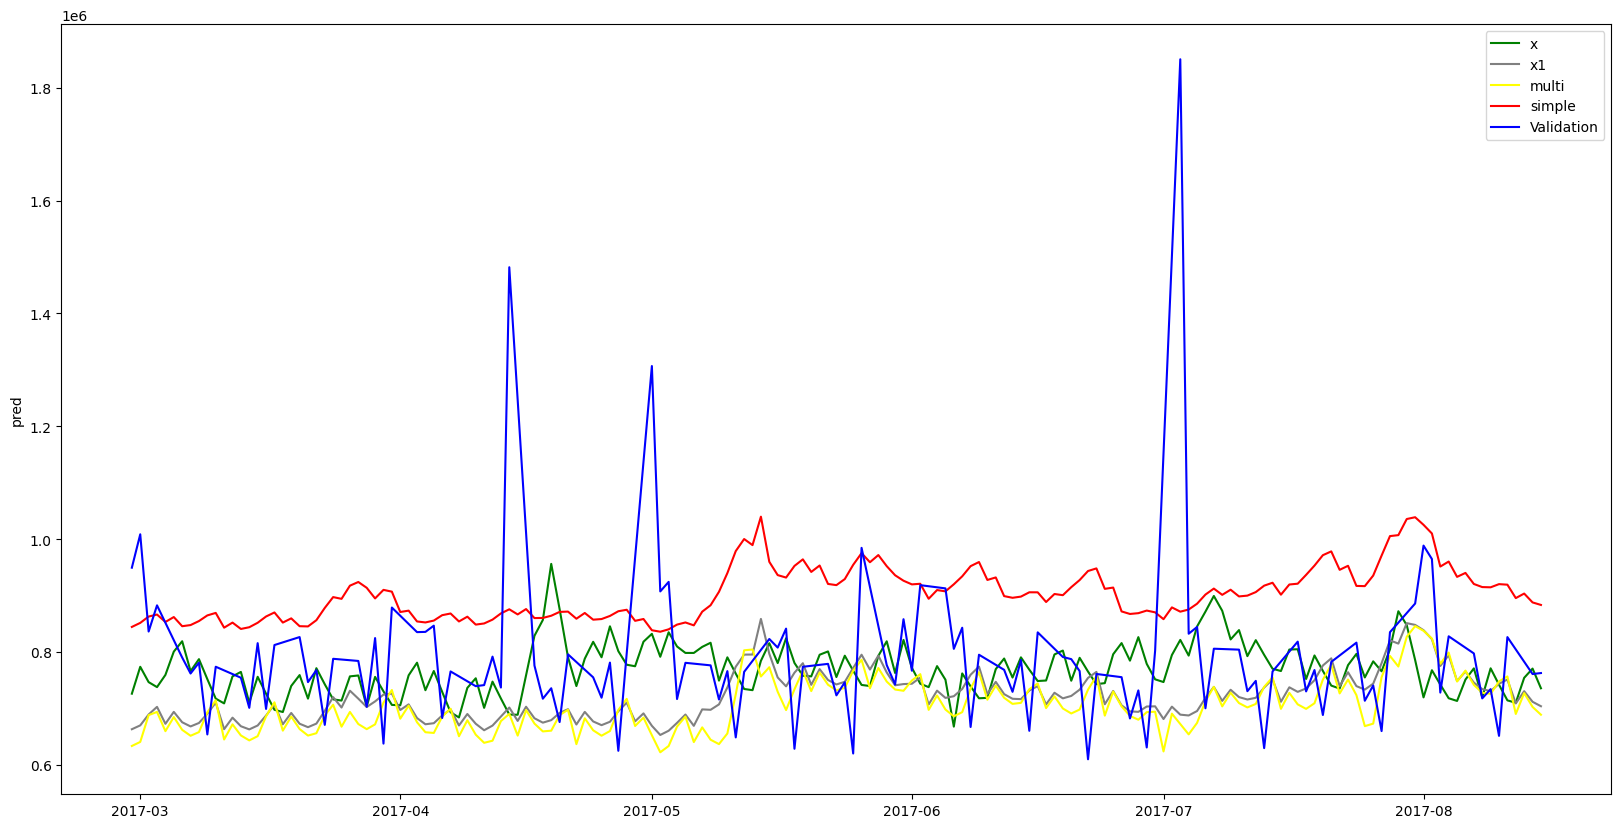

In [ ]:
plt.figure(figsize=(20, 10))

sns.lineplot(data=x_df, x=val.index, y='pred', color="green", label="x")
sns.lineplot(data=x1_df, x=val.index, y='pred', color="grey", label="x1")
sns.lineplot(data=multi_df, x=val.index, y='pred', color="yellow", label="multi")
sns.lineplot(data=simple_df, x=val.index, y='pred', color="red", label="simple")
sns.lineplot(data=val, x=val.index, y="sales", color="blue", label="Validation")

<Axes: ylabel='pred'>

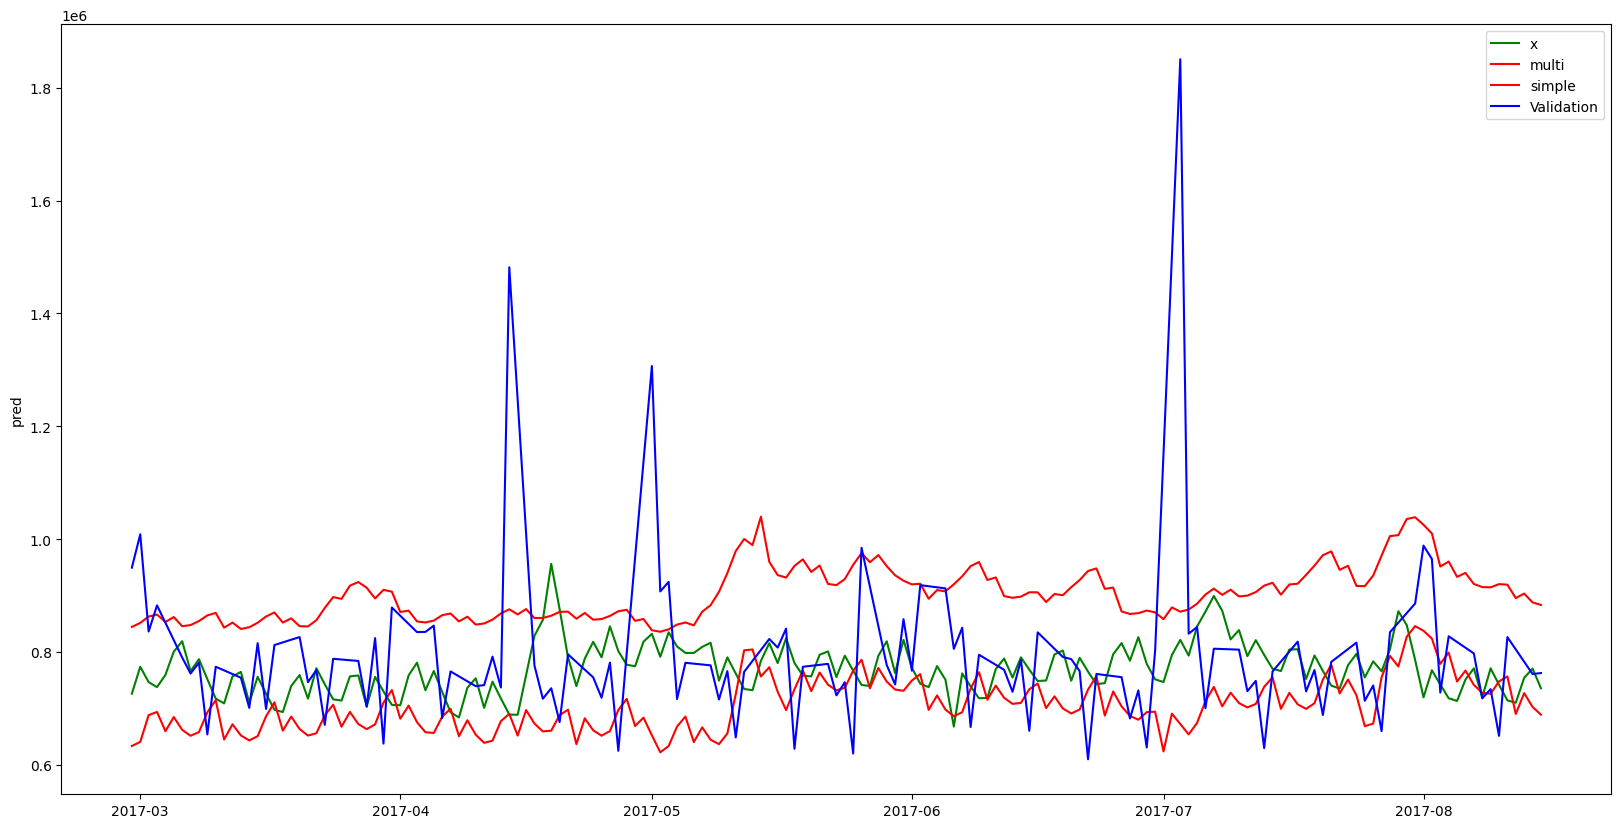

In [ ]:
plt.figure(figsize=(20, 10))

sns.lineplot(data=x_df, x=val.index, y='pred', color="green", label="x")
sns.lineplot(data=multi_df, x=val.index, y='pred', color="red", label="multi")
sns.lineplot(data=simple_df, x=val.index, y='pred', color="red", label="simple")
sns.lineplot(data=val, x=val.index, y="sales", color="blue", label="Validation")